#Loading All Essential Libraries:


In [ ]:
!ls

sample_data


In [1]:
#Clearing the existing session if any and installing java and spark

!ls
!rm -f spark-3.4.[01]-bin-hadoop3.tgz*
!rm -rf spark-3.4.[01]-bin-hadoop3
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar -xf spark-3.4.2-bin-hadoop3.tgz
!ls -alt


sample_data
--2024-03-28 17:17:48--  https://downloads.apache.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.208.237, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388664780 (371M) [application/x-gzip]
Saving to: ‘spark-3.4.2-bin-hadoop3.tgz’

spark-3.4.2-bin-had 100%[===================>] 370.66M  12.0MB/s    in 29s     

2024-03-28 17:18:18 (12.9 MB/s) - ‘spark-3.4.2-bin-hadoop3.tgz’ saved [388664780/388664780]

total 379576
drwxr-xr-x  1 root root      4096 Mar 28 17:18 .
drwxr-xr-x  1 root root      4096 Mar 28 17:15 ..
drwxr-xr-x  1 root root      4096 Mar 26 13:28 sample_data
drwxr-xr-x  4 root root      4096 Mar 26 13:27 .config
-rw-r--r--  1 root root 388664780 Nov 25 07:49 spark-3.4.2-bin-hadoop3.tgz
drwxr-xr-x 13 1000 1000      4096 Nov 25 07:48 spark-3.4.2-bin-hadoop3

In [2]:
# install findspark
!pip3 install findspark


In [3]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
#Initializing Spark with a custom app name Bikes_london, memory settings for driver & executors as 8 gigabites, and set the number of cores for executors as 2
spark_conf = SparkConf().setMaster('local[*]').setAppName('Bikes_london') \
                         .set("spark.driver.memory", "8g") \
                         .set("spark.executor.memory", "8g") \
                         .set("spark.executor.cores", "2")
sc = SparkContext(conf=spark_conf)



In [4]:

from pyspark.sql import *
from pyspark.sql.functions import *
spark = SparkSession.builder.appName("Bikes_london").getOrCreate()


#Loading the Zip File:


In [5]:
# get file for given year from TfL open data and unziping the file in the present directory
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip



--2024-03-28 17:18:42--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.212.132, 104.16.213.132
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.212.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   271MB/s    in 0.8s    

2024-03-28 17:18:43 (271 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  


In [6]:
!pwd

/content


In [7]:
# Load CSV files into a Spark DataFrame:
cyclehire =(spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load("/content/*.csv"))


#Data Exploration and Data Cleaning:


In [ ]:

# Top 10 Rows:
cyclehire.show(10)



+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|24/06/2014 00:39|            311|Foley Street, Fit...|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|03/07/2014 11:40|             22|Northington Stree...|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|05/07/2014 15:07|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|06/07/2014 16:14|            311|Foley Street, Fit...|
| 34956750|    1500|   8251|13/07/2014 00:41|          

In [ ]:

#Count of cyclehire Dataframe
count = cyclehire.count()
count

11481596

In [8]:
#datatypes of columns in cyclehire Dataframe
cyclehire.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [9]:
{col:cyclehire.filter(cyclehire[col].isNull()).count() for col in cyclehire.columns}

{'Rental Id': 1239113,
 'Duration': 1239113,
 'Bike Id': 1239113,
 'End Date': 1239113,
 'EndStation Id': 1239245,
 'EndStation Name': 1239245,
 'Start Date': 1239113,
 'StartStation Id': 1239113,
 'StartStation Name': 1239113}

In [ ]:
# Convert 'Duration' from string to integer
cyclehire = cyclehire.withColumn("Duration", col("Duration").cast("integer"))

In [ ]:
# Convert 'Start Date' from string to date format using to_Date
cyclehire = cyclehire.withColumn("Start Date", to_date("Start Date", "dd/MM/yyyy HH:mm"))

#Extracting Month from the 'Start Date'
cyclehire = cyclehire.withColumn("Month", month("Start Date"))


cyclehire.show()

+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|Month|
+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+
| 34263367|    1080|   9076|24/06/2014 00:57|          695|Islington Green, ...|2014-06-24|            311|Foley Street, Fit...|    6|
| 34603487|     660|   6328|03/07/2014 11:51|          695|Islington Green, ...|2014-07-03|             22|Northington Stree...|    7|
| 34689078|     120|   2006|05/07/2014 15:09|          357|Howland Street, F...|2014-07-05|            311|Foley Street, Fit...|    7|
| 34724273|    1260|   7904|06/07/2014 16:35|          695|Islington Green, ...|2014-07-06|            311|Foley Street, Fit...|    7|
| 34956750|    1500|   8251|13/07/2014 00:41|          

In [ ]:
import matplotlib.pyplot as plt
#Summary Stats for Duration
cyclehire.describe("Duration").show()

+-------+------------------+
|summary|          Duration|
+-------+------------------+
|  count|          10242483|
|   mean| 1466.081447242822|
| stddev|12946.838147599005|
|    min|             -3360|
|    max|           2596560|
+-------+------------------+



In [ ]:
#Null Count in the Duration column
null_count_Duration = cyclehire.filter(col("Duration").isNull()).count()
print("Number of null values in 'Duration':", null_count_Duration)

Number of null values in 'Duration': 1239113


In [ ]:
#Null Count in the 'Start Station' column
null_count_Start_station = cyclehire.filter(col("StartStation Name").isNull())
print("Number of null values in ' StartStation Name':", null_count_Start_station)
null_count_Start_station.show()

Number of null values in ' StartStation Name': DataFrame[Rental Id: string, Duration: int, Bike Id: string, End Date: string, EndStation Id: string, EndStation Name: string, Start Date: date, StartStation Id: string, StartStation Name: string, Month: int]
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-----+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|Month|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-----+
|     null|    null|   null|    null|         null|           null|      null|           null|             null| null|
|     null|    null|   null|    null|         null|           null|      null|           null|             null| null|
|     null|    null|   null|    null|         null|           null|      null|           null|             null| null|
|     null|    null|   null|  

In [ ]:
unique_rows = cyclehire.dropDuplicates().count()
total_rows =cyclehire.count()
duplicate_rows = total_rows - unique_rows
duplicate_rows

1239112

In [ ]:
# Convert to Pandas DataFrame for plotting
duration_pandas = cyclehire.select("Month", "Duration").toPandas()



In [ ]:

duration_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11481596 entries, 0 to 11481595
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Month     float64
 1   Duration  float64
dtypes: float64(2)
memory usage: 175.2 MB


<ipython-input-31-6fe5b4582e9c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Month", y="Duration", data=duration_pandas,palette="pastel")


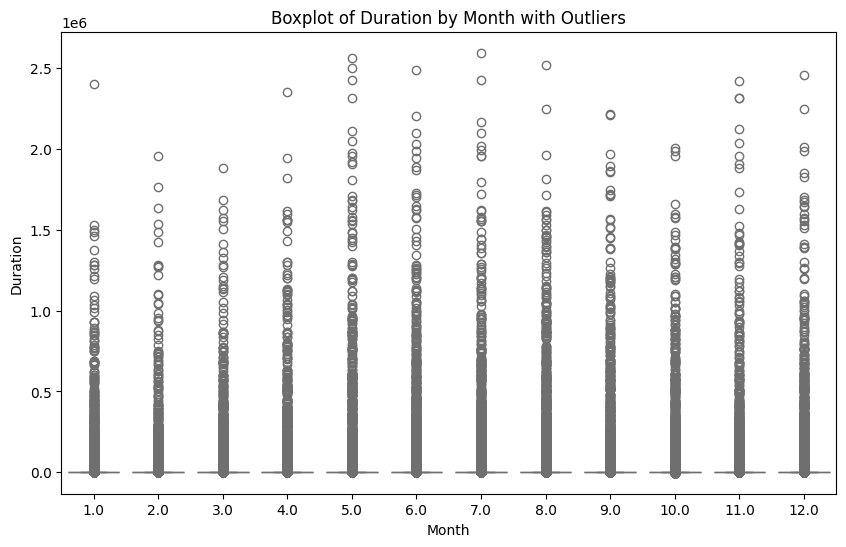

In [ ]:
import seaborn as sns
# Plot boxplot with outliers using Matplotlib
plt.figure(figsize=(10, 6))
sns.boxplot(x="Month", y="Duration", data=duration_pandas,palette="pastel")
plt.xlabel("Month")
plt.ylabel("Duration")
plt.title("Boxplot of Duration by Month with Outliers")
plt.show()

##Removing Anomalies:

In [ ]:
## Data in which Duration is less than or equal to zero
A = cyclehire.filter((col("Duration")<=0)| (col("Duration").isNull()))
A.show()
A.count()


+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|Start Date|StartStation Id|   StartStation Name|Month|
+---------+--------+-------+----------------+-------------+--------------------+----------+---------------+--------------------+-----+
| 34833716|       0|   8377|09/07/2014 16:10|           66|Holborn Circus, H...|2014-07-09|             66|Holborn Circus, H...|    7|
| 35040768|       0|  12611|15/07/2014 08:46|           74|Vauxhall Cross, V...|2014-07-15|             74|Vauxhall Cross, V...|    7|
| 34871642|       0|   3311|10/07/2014 16:49|          598|Southerton Road, ...|2014-07-10|            598|Southerton Road, ...|    7|
| 34724920|       0|   9969|06/07/2014 16:27|           13|Scala Street, Fit...|2014-07-06|             13|Scala Street, Fit...|    7|
| 35213542|       0|   1549|19/07/2014 10:36|          

1271615

In [ ]:
#removing the null values and storing it in a dataframe called cyclehire
cyclehire = cyclehire.where(cyclehire.Duration>0)
cyclehire.count()

10209981

In [ ]:
cyclehire.filter(col("StartStation Name").isNull()).count()

0

In [ ]:

#Removing the Duplicate Values and restoring it in a cyclehire
cyclehire = cyclehire.dropDuplicates().count()


10209981

In [ ]:
#Removing the outliers ie., Duration less than 90 seconds and duration greater than 7200 seconds
cyclehire = cyclehire.filter((col("Duration") >= 90 ) &
                                      (col("Duration") <= 7200))

In [ ]:
cyclehire.describe("Duration").show()


+-------+------------------+
|summary|          Duration|
+-------+------------------+
|  count|          10066878|
|   mean|1049.0428730734593|
| stddev| 904.8199781005692|
|    min|               120|
|    max|              7200|
+-------+------------------+



##Baylis, Waterloo Details

In [ ]:
baylis_road_rides = cyclehire.filter((col("StartStation Name").like("Baylis Road, Waterloo")))
baylis_road_rides.count()

26914

In [ ]:
baylis_road_avg_duration = baylis_road_rides.groupby("Month").agg({"Duration": "avg"}).orderBy("Month")
baylis_road_avg_duration.show()

+-----+-----------------+
|Month|    avg(Duration)|
+-----+-----------------+
|    1|737.4076561450638|
|    2|775.3235908141962|
|    3|766.6356589147287|
|    4|776.7362797474502|
|    5|854.4636095919226|
|    6|853.7414965986394|
|    7| 925.803842264914|
|    8|919.1619479048697|
|    9|821.9190076614374|
|   10|785.1288659793814|
|   11|710.4723618090452|
|   12| 738.684668989547|
+-----+-----------------+



In [ ]:
baylis_road_avg_duration_pandas = baylis_road_avg_duration.toPandas()

In [ ]:
baylis_monthly_durations = baylis_road_rides.groupBy("Month").agg(collect_list("Duration").alias("Durations_Baylis"))

In [ ]:
baylis_monthly_durations_pandas = baylis_monthly_durations.toPandas()

##Other Station Details

In [ ]:
other_station_rides = cyclehire.filter((cyclehire["StartStation Name"] != "Baylis Road, Waterloo Station"))

In [ ]:
other_station_rides

DataFrame[Rental Id: string, Duration: int, Bike Id: string, End Date: string, EndStation Id: string, EndStation Name: string, Start Date: date, StartStation Id: string, StartStation Name: string, Month: int]

In [ ]:
other_station_avg_duration = other_station_rides.groupby("Month").agg({"Duration": "avg"}).orderBy("Month")
other_station_avg_duration.show()

+-----+------------------+
|Month|     avg(Duration)|
+-----+------------------+
|    1| 887.2909169763108|
|    2| 939.7040878824047|
|    3| 1057.436136003787|
|    4|1090.0551734195367|
|    5| 1088.081605410078|
|    6| 1109.093966633432|
|    7|1130.1528238854646|
|    8|1164.4138821006065|
|    9|1053.3771040863592|
|   10| 989.8763721334637|
|   11| 923.0806632750389|
|   12|  970.154543967776|
+-----+------------------+



In [ ]:
other_station_avg_duration_pandas = other_station_avg_duration.toPandas()

In [ ]:
other_monthly_durations = other_station_rides.groupBy("Month").agg(collect_list("Duration").alias("Durations_Other"))

In [ ]:
other_monthly_durations_pandas = other_monthly_durations.toPandas()
other_monthly_durations_pandas

,Month,Durations_Other
0,6,"[1080, 900, 300, 600, 660, 780, 540, 720, 600,..."
1,5,"[1140, 660, 1560, 1380, 1620, 1080, 840, 840, ..."
2,3,"[1380, 1500, 1440, 1380, 1440, 1200, 180, 1380..."
3,1,"[1140, 1560, 1200, 1380, 1320, 1080, 1440, 144..."
4,12,"[1380, 1680, 1200, 1320, 180, 480, 300, 420, 4..."
5,7,"[660, 120, 1260, 1500, 1380, 2820, 180, 420, 1..."
6,4,"[300, 1920, 3000, 2700, 2280, 240, 720, 660, 7..."
7,8,"[1860, 960, 1140, 480, 2100, 780, 660, 600, 60..."
8,9,"[120, 1080, 2820, 1620, 480, 1080, 1380, 3060,..."
9,10,"[360, 720, 180, 1020, 1320, 840, 600, 660, 960..."


#Statistical Analysis

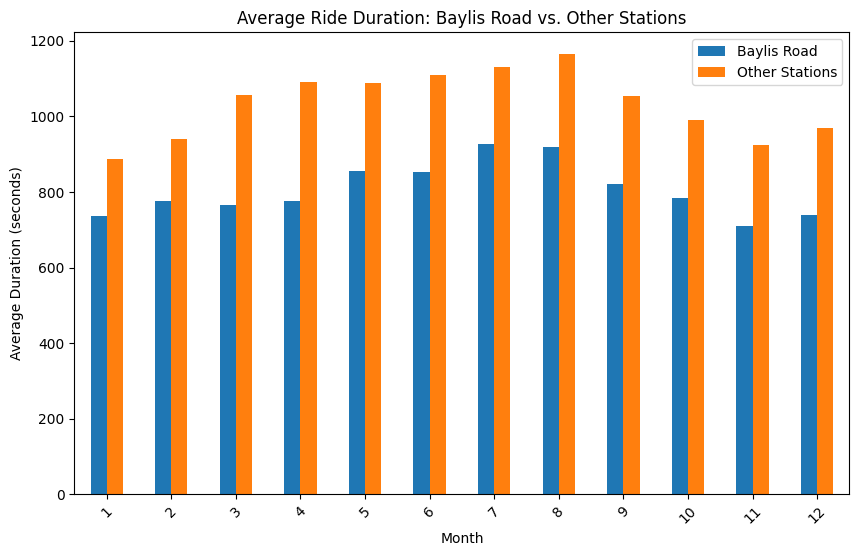

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Combining the avgerage durations of both to visualize
combined_df = baylis_road_avg_duration_pandas.merge(other_station_avg_duration_pandas, on='Month', suffixes=('_Baylis', '_Other'))
combined_df.set_index('Month', inplace=True)
combined_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Average Duration (seconds)')
plt.title('Average Ride Duration: Baylis Road vs. Other Stations')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(['Baylis Road', 'Other Stations'])
plt.show()

In [ ]:
# Convert Pandas Series to arrays
baylis_road_durations = baylis_road_rides.select("Duration").toPandas()["Duration"].astype(float).values
other_station_durations = other_station_rides.select("Duration").toPandas()["Duration"].astype(float).values

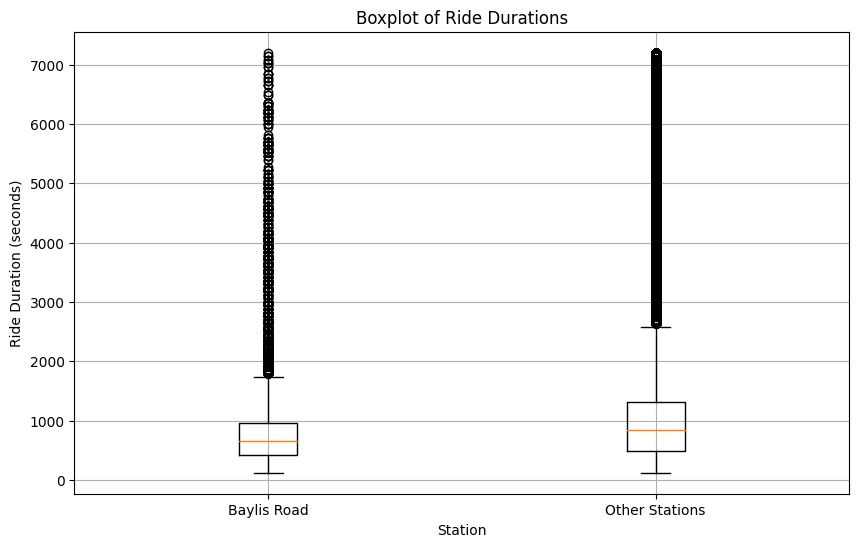

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([baylis_road_durations, other_station_durations], labels=['Baylis Road', 'Other Stations'])
plt.xlabel('Station')

plt.ylabel('Ride Duration (seconds)')
plt.title('Boxplot of Ride Durations')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import ttest_ind
for month in range(1,13):
  baylis_durations = baylis_monthly_durations_pandas[baylis_monthly_durations_pandas['Month'] == month]['Durations_Baylis'].values[0]
  other_durations = other_monthly_durations_pandas[other_monthly_durations_pandas['Month'] == month]['Durations_Other'].values[0]
  t_stat, p_val = ttest_ind(baylis_durations, other_durations, equal_var=False)  # Using Welch's t-test

  print(f'Month: {month}, T-statistic: {t_stat}, P-value: {p_val}')


Month: 1, T-statistic: -10.165251645928988, P-value: 1.6016057794460003e-23
Month: 2, T-statistic: -10.270432476698222, P-value: 6.1862243392770346e-24
Month: 3, T-statistic: -21.477724339487512, P-value: 4.5849281857983135e-92
Month: 4, T-statistic: -24.911824215337262, P-value: 3.745975235693533e-120
Month: 5, T-statistic: -15.000383834128451, P-value: 1.1025104589107031e-48
Month: 6, T-statistic: -19.36017518006243, P-value: 2.9969920556755436e-78
Month: 7, T-statistic: -13.691833188617627, P-value: 1.9712812243143243e-41
Month: 8, T-statistic: -15.393231043718451, P-value: 2.723840201820637e-51
Month: 9, T-statistic: -18.64836689743181, P-value: 3.3244090713137666e-73
Month: 10, T-statistic: -16.393214318974408, P-value: 2.850898952373374e-57
Month: 11, T-statistic: -18.247514204991752, P-value: 5.77616448632208e-69
Month: 12, T-statistic: -18.323290447350928, P-value: 3.79254239966668e-70
